In [1]:
# config
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

plt.style.use("jupno.mplstyle")
%matplotlib notebook
from orm import WorkDatabaseWizard
from spectrum import DummyPlotter, LtAverager


rcParams["lines.linewidth"] = 1
rcParams["lines.markersize"] = 2

apm_unit = "area per molecule/ $\mathring{A}^{2}$"

wz = WorkDatabaseWizard()

def match_lt(wz, criteria):
    
    out = []
    temp = wz.session.query(wz.lt, wz.regular_lt).join(wz.regular_lt, wz.regular_lt.ltid == wz.lt.id).filter(wz.lt.type == "lt").all()
    
    for tup in temp:
        if tup[1].ratio == criteria[0]:
            if tup[1].surfactant == criteria[1]:
                if tup[1].sensitizer == criteria[2]:
                    lt = wz.construct_lt(tup[0])
                    lt.x = lt.apm
                    lt.x_unit = apm_unit
                    out.append(lt)
    
    return out


def lt_filter(wz, attribute_target):
    """This function takes a DatabaseWizard and a dictionary of the desired search criteria (attributes of the regular_lt ORM class) and 
    returns a list of LtIsotherm objects matching the requested criteria."""
    
    out = []
    temp = wz.session.query(wz.lt, wz.regular_lt).join(wz.regular_lt, wz.regular_lt.ltid == wz.lt.id).filter(wz.lt.type == "lt")
    
    for key in attribute_target:
        temp = temp.filter(getattr(wz.regular_lt, key) == attribute_target[key])
    
    for tup in temp.all():
                    lt = wz.construct_lt(tup[0])
                    lt.x = lt.apm
                    lt.x_unit = apm_unit
                    out.append(lt)
                    
    return out


def calc_spreading_volume(area_per_molecule, concentration=1, area=20.43):
    """
    concentration in milimole per liter
    area in square centimeter
    area per molecule in square angstroem per molecule
    
    returns: spreading volume in microliter
    """
    
    area = 1e16*area
    concentration = concentration/1000
    vol = area/(area_per_molecule*6.022e23*concentration)
    return vol*1e6


l = {"sensitizer": "BX12", "surfactant":"SA", "ratio": "1to2"}
l = lt_filter(wz, l)

                                             

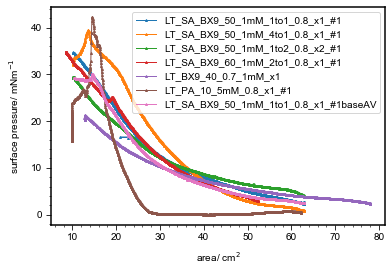

In [2]:
a = ("1to1", "SA", "BX9")
b = ("1to2", "SA", "BX9")
c = ("2to1", "SA", "BX9")              
d = ("4to1", "SA", "BX9")
e = ("1to4", "SA", "BX9") 

a_list = match_lt(wz, a)
b_list = match_lt(wz, b)
c_list = match_lt(wz, c)
d_list = match_lt(wz, d)
e_list = match_lt(wz, e)

a_ex = a_list[0]
b_ex = b_list[0]
c_ex = c_list[0]
d_ex = d_list[0]
e_ex = e_list[0]

new = [a_ex, b_ex, c_ex, d_ex]

ya = match_lt(wz, (None, "YA", None))[0]
bx12 = match_lt(wz, (None, None, "BX12"))
bx9 = match_lt(wz, (None, None, "BX9"))[4]
sa = match_lt(wz, (None, "SA", None))[0]
pa = match_lt(wz, (None, "PA", None))[0]

fatty = [ya, pa, sa]


new = [a_ex, b_ex, c_ex, d_ex, bx9, pa]
#new = [i.cut_away_decay() for i in new]

test = LtAverager(new).average_lt()

new.append(test)
DummyPlotter(new).plot_all()

In [ ]:
def write_html():
    
    top = """
        <html>
    <head>
        <link rel="stylesheet" href="test.css">
    </head>
    <body>

    <table class="lt">

        <tr>
            <th>Filename</th>
            <th>measured</th>
            <th>Surfactant</th>
            <th>Sensitizer</th>
            <th>Ratio</th>
        </tr>
    """
    
    bottom = """
    </table>


    </body>
    </html>
        """
    out = ""
    temp = wz.session.query(wz.regular_lt)
    for item in temp:
        for atr in ("name","id", "surfactant", "sensitizer","ratio"):
            out += f'<td>{getattr(item, atr)}</td>\n'
        
        out += "<td><button>Plot</button></td>\n"
        out += f'</tr>\n'
    
    return top+out+bottom

with open("lt.html", "w") as outfile:
    outfile.write(write_html())

In [ ]:
print(l)

In [ ]:
import plotly.graph_objs as go

lt = l[0]
lt2 = l[1]
lt3 = l[2]
print(lt.x_unit)
fig = go.Figure()
fig.add_trace(go.Scatter(x=lt.x, y=lt.y, mode='lines', name=lt.name))
fig.add_trace(go.Scatter(x=lt2.x, y=lt2.y, mode='lines', name=lt2.name))

fig.update_layout(title='lt', xaxis_title= r'$\mathrm{area~per~molecule/~}\mathring{A}^{2}$' , yaxis_title= r'$\mathrm{surface~pressure/~(mNm}^{-1})$')


fig.show()

In [ ]:

fig.add_trace(go.Scatter(x=lt3.x, y=lt3.y, mode='lines', name=lt3.name))


In [ ]:
def plot_lts_plotly(lts, title='lt'):
    
    fig = go.Figure()
    
    for item in lts:
        fig.add_trace(go.Scattergl(x=item.x, y=item.y, mode='lines', name=item.name))
        
    fig.update_layout(title=title, xaxis_title= r'$\mathrm{area~per~molecule/~}\mathring{A}^{2}$' , yaxis_title= r'$\mathrm{surface~pressure/~(mNm}^{-1})$')
    fig.show()

    
plot_lts_plotly(l)

In [ ]:
def traverse_lt_results(wz):
    
    for surfactant in ("PA", "SA", "YA"):
        for sensitizer in ("BX9", "BX12"):
            for ratio in ("1to1", "2to1", "1to2", "4to1", "1to4"):
                
                criteria_dic = {"sensitizer": sensitizer, "surfactant": surfactant, "ratio": ratio}
                lts = lt_filter(wz, criteria_dic)
                plot_lts_plotly(lts, title=surfactant+" "+sensitizer+" "+ratio)
                
                
traverse_lt_results(wz)